**Mount Google Drive for dataset**

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
import numpy as np
import cv2
from scipy import signal
import os
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
from tqdm import tqdm
import os.path as osp
from google.colab import drive
import random
from sklearn.metrics import confusion_matrix

**1D Reference Pattern**

In [5]:
class ScannerIdentification1D:
    def __init__(self):
        """Initialize Scanner Identification using 1D Linear Row Reference Pattern"""
        self.reference_patterns = {}
        self.scanner_names = []

    def extract_noise(self, image, return_denoised=False):
        """
        Extract noise from an image using LPA-ICI (Local Polynomial Approximation -
        Intersection of Confidence Intervals)

        Args:
            image: Input image
            return_denoised: If True, returns both noise and denoised image

        Returns:
            noise: Extracted noise pattern
            denoised (optional): Denoised image if return_denoised is True
        """


        # Convert to grayscale if the image is colored
        if len(image.shape) == 3:
            gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        else:
            gray_image = image.copy()

        # Apply LPA-ICI denoising instead of Gaussian blur
        denoised = self.lpa_ici_denoising(gray_image)

        # Extract noise by subtracting denoised image from original
        noise = gray_image.astype(np.float32) - denoised.astype(np.float32)

        if return_denoised:
            return noise, denoised
        return noise

    def lpa_ici_denoising(self, image):
        """
        Perform LPA-ICI denoising on the input image

        Args:
            image: Input grayscale image

        Returns:
            denoised: Denoised image using LPA-ICI method
        """

        # Convert to float for processing
        img_float = image.astype(np.float32)

        # Define a set of directional windows (8 directions)
        directions = np.linspace(0, np.pi, 8, endpoint=False)

        # Define a set of scales (window sizes)
        h_values = [3, 5, 7, 9, 11, 13]

        # Initialize the result image
        denoised = np.zeros_like(img_float)
        weights_sum = np.zeros_like(img_float)

        # Apply LPA filtering with different scales and directions
        for direction in directions:
            # For each direction, apply ICI rule to select best scale
            direction_estimate = np.zeros_like(img_float)
            direction_weights = np.zeros_like(img_float)

            for h in h_values:
                # Create directional kernel for this scale and direction
                kernel = self.create_directional_kernel(h, direction)

                # Apply kernel to image
                filtered = cv2.filter2D(img_float, -1, kernel)

                # Calculate standard deviation estimate for this kernel
                # (this is a simplification - in a full implementation, you'd
                # estimate local noise variance more accurately)
                std_dev = np.std(image) / np.sqrt(np.sum(kernel > 0))

                # Apply ICI rule to determine if this scale should be used
                # This is a simplified version of the ICI rule
                if h == h_values[0]:
                    # Initialize with smallest scale
                    direction_estimate = filtered
                    direction_weights = np.ones_like(img_float)
                else:
                    # Calculate confidence intervals
                    upper_bound = direction_estimate + 2 * std_dev
                    lower_bound = direction_estimate - 2 * std_dev

                    # Check if new estimate is within confidence intervals
                    valid_mask = (filtered >= lower_bound) & (filtered <= upper_bound)

                    # Update direction estimate only for valid pixels
                    direction_weights[valid_mask] += 1
                    direction_estimate[valid_mask] = (direction_estimate[valid_mask] *
                                                     (direction_weights[valid_mask] - 1) +
                                                     filtered[valid_mask]) / direction_weights[valid_mask]

            # Accumulate direction estimates
            denoised += direction_estimate
            weights_sum += np.ones_like(img_float)

        # Average all direction estimates
        denoised = denoised / weights_sum

        return denoised

    def create_directional_kernel(self, h, direction):
        """
        Create a directional kernel for LPA filtering

        Args:
            h: Kernel size (scale)
            direction: Direction in radians

        Returns:
            kernel: Directional kernel
        """

        # Create a h x h kernel
        kernel = np.zeros((h, h), dtype=np.float32)
        center = h // 2

        # Calculate direction vector
        dx = np.cos(direction)
        dy = np.sin(direction)

        # Fill kernel based on direction
        for i in range(h):
            for j in range(h):
                # Distance from center along the direction
                dist_along = abs((i - center) * dy - (j - center) * dx)
                dist_perp = abs((i - center) * dx + (j - center) * dy)

                # Use Gaussian-like weighting
                if dist_perp < h/4:  # Only include points close to the directional line
                    kernel[i, j] = np.exp(-(dist_along**2 + dist_perp**2) / (h/2)**2)

        # Normalize kernel
        if np.sum(kernel) > 0:
            kernel = kernel / np.sum(kernel)

        return kernel

    def extract_1d_noise_pattern(self, noise):
        """
        Extract 1D linear row reference pattern from 2D noise

        Args:
            noise: 2D noise pattern

        Returns:
            row_pattern: 1D linear row reference pattern
        """

        # Average across all rows to get a 1D pattern
        row_pattern = np.mean(noise, axis=0)

        return row_pattern

    def create_reference_pattern(self, image_folder, scanner_name, num_train_images=100):
        """
        Create a 1D linear reference pattern for a scanner from multiple images

        Args:
            image_folder (str): Path to folder containing images from a scanner
            scanner_name (str): Name identifier for the scanner
            num_train_images (int): Number of images to use for reference pattern
        """

        print(f"Creating 1D reference pattern for scanner: {scanner_name}")

        # Get list of image files
        image_files = [os.path.join(image_folder, f) for f in os.listdir(image_folder)
                     if f.lower().endswith(('.png', '.jpg', '.jpeg', '.tiff', '.bmp'))]

        # Limit to the number of training images
        if len(image_files) > num_train_images:
            image_files = image_files[:num_train_images]

        # Process the first image to get dimensions
        first_image = cv2.imread(image_files[0], cv2.IMREAD_GRAYSCALE)
        first_noise = self.extract_noise(first_image)
        first_1d_pattern = self.extract_1d_noise_pattern(first_noise)

        # Initialize accumulated 1D pattern
        accumulated_1d_pattern = np.zeros_like(first_1d_pattern, dtype=np.float32)

        # Process each image and accumulate 1D noise patterns
        for img_path in tqdm(image_files):
            image = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)

            # Handle different sized images by resizing
            if image.shape[1] != first_image.shape[1]:
                image = cv2.resize(image, (first_image.shape[1], image.shape[0]))

            # Extract 2D noise from image
            noise = self.extract_noise(image)

            # Extract 1D pattern from noise
            pattern_1d = self.extract_1d_noise_pattern(noise)

            # Accumulate 1D pattern
            accumulated_1d_pattern += pattern_1d

        # Average accumulated 1D pattern to create reference pattern
        reference_pattern_1d = accumulated_1d_pattern / len(image_files)

        # Store reference pattern
        self.reference_patterns[scanner_name] = reference_pattern_1d
        if scanner_name not in self.scanner_names:
            self.scanner_names.append(scanner_name)

        return reference_pattern_1d

    def identify_scanner(self, image):
        """
        Identify the source scanner of an image using 1D reference pattern

        Args:
            image: Input image for identification

        Returns:
            scanner_name: Name of the identified scanner
            correlations: Dictionary of correlation values for each scanner
        """

        # Check if reference patterns exist
        if not self.reference_patterns:
            raise ValueError("No reference patterns available. Create reference patterns first.")

        # Convert to grayscale if the image is colored
        if len(image.shape) == 3:
            gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        else:
            gray_image = image.copy()

        # Extract 2D noise from the image
        noise = self.extract_noise(gray_image)

        # Extract 1D pattern from noise
        pattern_1d = self.extract_1d_noise_pattern(noise)

        # Calculate correlation between 1D pattern and each reference pattern
        correlations = {}
        for scanner_name, ref_pattern in self.reference_patterns.items():
            # Handle different sized patterns by resizing
            if pattern_1d.shape[0] != ref_pattern.shape[0]:
                pattern_resized = cv2.resize(pattern_1d.reshape(1, -1),
                                            (ref_pattern.shape[0], 1))[0]
            else:
                pattern_resized = pattern_1d

            # Calculate correlation
            correlation = self.calculate_correlation(pattern_resized, ref_pattern)
            correlations[scanner_name] = correlation

        # Determine the scanner with the highest correlation
        identified_scanner = max(correlations, key=correlations.get)

        return identified_scanner, correlations

    def calculate_correlation(self, X, Y):
        """
        Calculate correlation between two vectors X and Y
        """

        X_mean = np.mean(X)
        Y_mean = np.mean(Y)

        X_centered = X - X_mean
        Y_centered = Y - Y_mean

        numerator = np.sum(X_centered * Y_centered)
        denominator = np.sqrt(np.sum(X_centered**2) * np.sum(Y_centered**2))

        if denominator == 0:
            return 0

        return numerator / denominator

    def evaluate(self, test_folders, scanner_names, num_test_images=100, save_images=False, output_dir=None):
        """
        Evaluate the identification accuracy on test images

        Args:
            test_folders (list): List of folders containing test images
            scanner_names (list): List of scanner names corresponding to test_folders
            num_test_images (int): Number of images to use for testing from each folder
            save_images (bool): Whether to save original, denoised, and noise images
            output_dir (str): Directory to save processed images if save_images is True

        Returns:
            accuracy (float): Overall accuracy
            conf_matrix (array): Confusion matrix
        """

        if not self.reference_patterns:
            raise ValueError("No reference patterns available. Create reference patterns first.")

        # Check if we have the same number of test folders and scanner names
        if len(test_folders) != len(scanner_names):
            raise ValueError("Number of test folders and scanner names must match")

        # Create output directory if saving images
        if save_images and output_dir is not None:
            os.makedirs(output_dir, exist_ok=True)

        true_labels = []
        predicted_labels = []
        image_paths = []  # Store paths for later visualization

        # Process test images from each scanner
        for folder_idx, (folder, scanner) in enumerate(zip(test_folders, scanner_names)):
            # Get list of test image files
            image_files = [os.path.join(folder, f) for f in os.listdir(folder)
                         if f.lower().endswith(('.png', '.jpg', '.jpeg', '.tiff', '.bmp'))]

            # Limit to the number of test images
            if len(image_files) > num_test_images:
                image_files = image_files[:num_test_images]

            # Create scanner subfolder if saving images
            if save_images and output_dir is not None:
                scanner_outdir = os.path.join(output_dir, scanner)
                os.makedirs(scanner_outdir, exist_ok=True)

            # Test each image
            for img_idx, img_path in enumerate(tqdm(image_files, desc=f"Testing {scanner}")):
                image = cv2.imread(img_path)

                # Convert to grayscale if the image is colored
                if len(image.shape) == 3:
                    gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
                else:
                    gray_image = image.copy()

                # Extract noise and get denoised image
                noise, denoised = self.extract_noise(gray_image, return_denoised=True)

                # Extract 1D pattern for visualization if saving images
                pattern_1d = self.extract_1d_noise_pattern(noise)

                # Identify scanner
                identified_scanner, correlations = self.identify_scanner(gray_image)

                # Save images if requested
                if save_images and output_dir is not None:
                    import matplotlib.pyplot as plt

                    # Create unique identifier for this image
                    base_filename = f"{scanner}_img{img_idx}"

                    # Normalize noise for visualization (from -255..255 to 0..255)
                    noise_vis = ((noise - np.min(noise)) / (np.max(noise) - np.min(noise) + 1e-10) * 255).astype(np.uint8)

                    # Save original, denoised, and noise images
                    cv2.imwrite(os.path.join(scanner_outdir, f"{base_filename}_original.png"), gray_image)
                    cv2.imwrite(os.path.join(scanner_outdir, f"{base_filename}_denoised.png"), denoised)
                    cv2.imwrite(os.path.join(scanner_outdir, f"{base_filename}_noise.png"), noise_vis)

                    # Save 1D pattern as a plot
                    plt.figure(figsize=(10, 3))
                    plt.plot(pattern_1d)
                    plt.title(f"1D Noise Pattern - {scanner} (Image {img_idx})")
                    plt.xlabel("Column Index")
                    plt.ylabel("Average Noise Value")
                    plt.grid(True, alpha=0.3)
                    plt.tight_layout()
                    plt.savefig(os.path.join(scanner_outdir, f"{base_filename}_1d_pattern.png"))
                    plt.close()

                    # Save correlation values to text file
                    with open(os.path.join(scanner_outdir, f"{base_filename}_correlations.txt"), 'w') as f:
                        f.write(f"True scanner: {scanner}\n")
                        f.write(f"Predicted scanner: {identified_scanner}\n\n")
                        f.write("Correlation values:\n")
                        for scanner_name, corr_val in correlations.items():
                            f.write(f"{scanner_name}: {corr_val:.6f}\n")

                # Record results
                true_labels.append(scanner)
                predicted_labels.append(identified_scanner)
                image_paths.append((img_path, scanner, identified_scanner))

        # Calculate accuracy
        correct = sum(1 for true, pred in zip(true_labels, predicted_labels) if true == pred)
        accuracy = correct / len(true_labels)

        # Create confusion matrix
        unique_scanners = list(set(true_labels + predicted_labels))
        conf_matrix = confusion_matrix(true_labels, predicted_labels, labels=unique_scanners)

        return accuracy, conf_matrix, unique_scanners, image_paths

    def visualize_samples(self, image_paths, num_samples=5):
        """
        Visualize original, denoised, noise images, and 1D pattern for a few samples

        Args:
            image_paths: List of (path, true_label, pred_label) tuples
            num_samples: Number of samples to visualize
        """

        # Randomly select samples to visualize
        if len(image_paths) > num_samples:
            samples = random.sample(image_paths, num_samples)
        else:
            samples = image_paths

        # Visualize each sample
        for i, (img_path, true_label, pred_label) in enumerate(samples):
            image = cv2.imread(img_path)

            # Convert to grayscale if the image is colored
            if len(image.shape) == 3:
                gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
            else:
                gray_image = image.copy()

            # Extract noise and get denoised image
            noise, denoised = self.extract_noise(gray_image, return_denoised=True)

            # Extract 1D pattern
            pattern_1d = self.extract_1d_noise_pattern(noise)

            # Normalize noise for visualization
            noise_vis = ((noise - np.min(noise)) / (np.max(noise) - np.min(noise) + 1e-10) * 255).astype(np.uint8)

            # Create figure
            plt.figure(figsize=(15, 8))

            # Plot original image
            plt.subplot(2, 2, 1)
            plt.imshow(gray_image, cmap='gray')
            plt.title('Original Image')
            plt.axis('off')

            # Plot denoised image
            plt.subplot(2, 2, 2)
            plt.imshow(denoised, cmap='gray')
            plt.title('Denoised Image (LPA-ICI)')
            plt.axis('off')

            # Plot noise
            plt.subplot(2, 2, 3)
            plt.imshow(noise_vis, cmap='gray')
            plt.title('Extracted Noise')
            plt.axis('off')

            # Plot 1D pattern
            # plt.subplot(2, 2, 4)
            # plt.plot(pattern_1d)
            # plt.title('1D Linear Row Reference Pattern')
            # plt.xlabel('Column Index')
            # plt.ylabel('Average Noise Value')
            # plt.grid(True, alpha=0.3)

            plt.suptitle(f"Sample {i+1}: True={true_label}, Predicted={pred_label} ({'Correct' if true_label == pred_label else 'Incorrect'})")
            plt.tight_layout()
            plt.show()

    def visualize_reference_patterns(self):
        """Visualize 1D reference patterns for all scanners"""

        if not self.reference_patterns:
            print("No reference patterns available.")
            return

        plt.figure(figsize=(10, 6))

        for scanner_name, pattern in self.reference_patterns.items():
            # Plot each reference pattern
            plt.plot(pattern, label=scanner_name)

        plt.title("1D Linear Row Reference Patterns Comparison")
        plt.xlabel("Column Index")
        plt.ylabel("Average Noise Value")
        plt.grid(True, alpha=0.3)
        plt.legend()
        plt.tight_layout()
        plt.show()

Creating reference pattern for S1 with 1 training image
Creating 1D reference pattern for scanner: S1


100%|██████████| 1/1 [00:03<00:00,  3.41s/it]


Creating reference pattern for S2 with 1 training image
Creating 1D reference pattern for scanner: S2


100%|██████████| 1/1 [00:03<00:00,  3.07s/it]


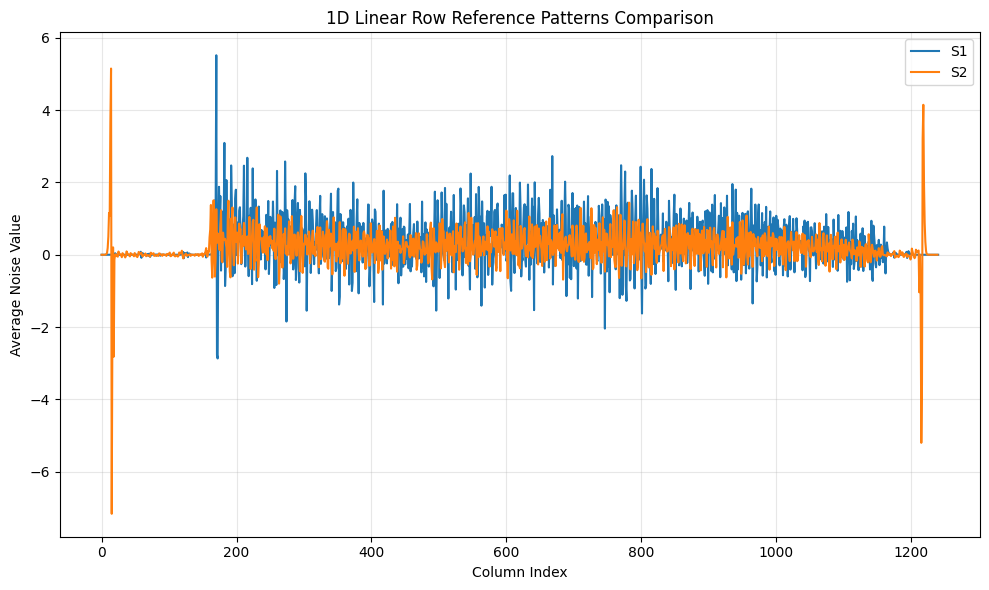

Testing S2: 100%|██████████| 1/1 [00:07<00:00,  7.33s/it]



Overall accuracy: 100.00%

Confusion Matrix:
Predicted ->
True | S2 S1
S2 |   1   0
S1 |   0   1
Accuracy for S2: 100.00%
Correct: 1/1
Accuracy for S1: 100.00%
Correct: 1/1

Visualizing sample images:


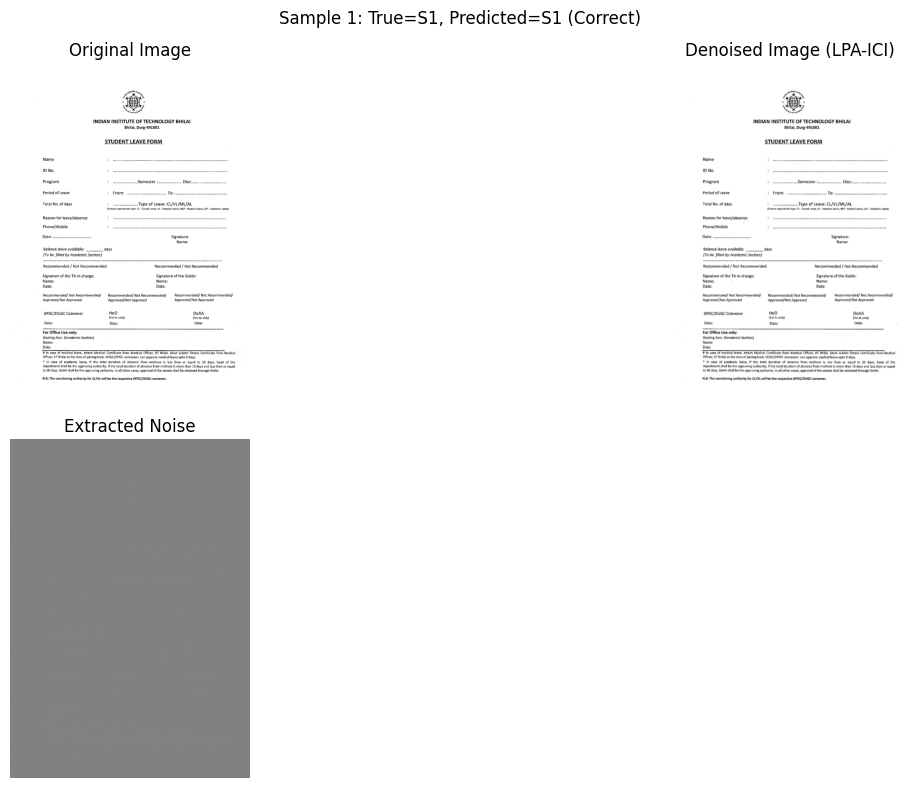

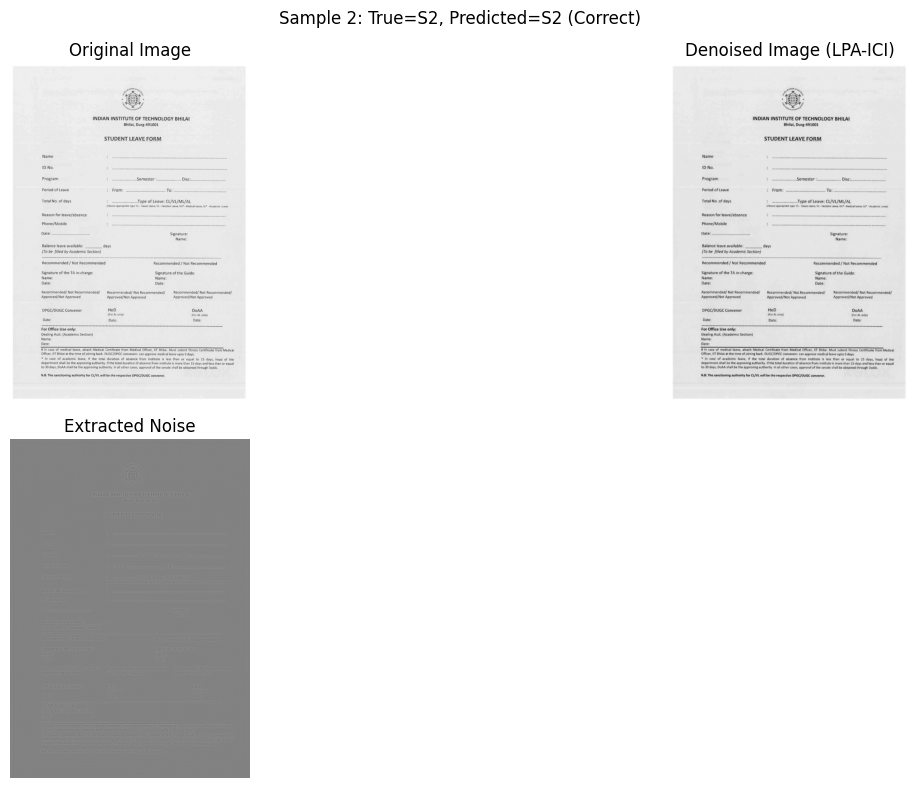

In [10]:
import os
import numpy as np
from sklearn.model_selection import train_test_split
import shutil

# Example usage
if __name__ == "__main__":
    # Initialize scanner identification
    scanner_id = ScannerIdentification1D()

    # Define paths to scanner folders (containing all images)
    scanner_folders = [
        "/content/drive/MyDrive/Scanner_Dataset2/Scanner1",
        "/content/drive/MyDrive/Scanner_Dataset2/Scanner2",
    ]

    scanner_names = ["S1", "S2"]

    # Create output directories
    output_dir = "/content/processed_images"
    temp_train_dir = "/content/temp_train"
    temp_test_dir = "/content/temp_test"

    os.makedirs(output_dir, exist_ok=True)
    os.makedirs(temp_train_dir, exist_ok=True)
    os.makedirs(temp_test_dir, exist_ok=True)

    # Process each scanner
    for folder, name in zip(scanner_folders, scanner_names):
        # Create scanner-specific subdirectories
        scanner_train_dir = os.path.join(temp_train_dir, name)
        scanner_test_dir = os.path.join(temp_test_dir, name)
        os.makedirs(scanner_train_dir, exist_ok=True)
        os.makedirs(scanner_test_dir, exist_ok=True)

        # Get the first image found in the folder
        image_path = None
        for root, _, files in os.walk(folder):
            for file in files:
                if file.lower().endswith(('.png', '.jpg', '.jpeg', '.tif', '.tiff', '.bmp')):
                    image_path = os.path.join(root, file)
                    break
            if image_path:
                break

        if not image_path:
            raise ValueError(f"No image found in {folder}")

        # Use the same image for both training and testing
        shutil.copy(image_path, os.path.join(scanner_train_dir, f"{name}_0000.jpg"))
        shutil.copy(image_path, os.path.join(scanner_test_dir, f"{name}_0000.jpg"))

    # Now use the temporary directories for training and testing
    train_folders = [os.path.join(temp_train_dir, name) for name in scanner_names]
    test_folders = [os.path.join(temp_test_dir, name) for name in scanner_names]

    # Create reference patterns for each scanner (using 1 training image)
    for folder, name in zip(train_folders, scanner_names):
        print(f"Creating reference pattern for {name} with 1 training image")
        scanner_id.create_reference_pattern(folder, name, num_train_images=1)

    # Visualize reference patterns
    scanner_id.visualize_reference_patterns()

    # Evaluate on test images (using the same image)
    accuracy, conf_matrix, labels, image_paths = scanner_id.evaluate(
        test_folders,
        scanner_names,
        num_test_images=1,
        save_images=True,
        output_dir=output_dir
    )

    # Print results
    print(f"\nOverall accuracy: {accuracy * 100:.2f}%")
    print("\nConfusion Matrix:")
    print("Predicted ->")
    print("True |", end="")
    for label in labels:
        print(f" {label}", end="")
    print()

    for i, label in enumerate(labels):
        print(f"{label} |", end="")
        for j in range(len(labels)):
            print(f" {conf_matrix[i][j]:3d}", end="")
        print()

    # Calculate individual accuracies
    for i, label in enumerate(labels):
        scanner_accuracy = conf_matrix[i, i] / np.sum(conf_matrix[i, :])
        print(f"Accuracy for {label}: {scanner_accuracy * 100:.2f}%")
        print(f"Correct: {conf_matrix[i, i]}/{np.sum(conf_matrix[i, :])}")

    # Visualize samples
    print("\nVisualizing sample images:")
    scanner_id.visualize_samples(image_paths, num_samples=5)

    # Clean up temporary directories
    shutil.rmtree(temp_train_dir)
    shutil.rmtree(temp_test_dir)

**========================================================================================================================================================================================================================**

**2D Reference Pattern**

In [12]:
import os
import cv2
import numpy as np
from tqdm import tqdm
import random
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

class ScannerIdentification2D:
    def __init__(self):
        """Initialize Scanner Identification using 2D Reference Patterns"""
        self.reference_patterns = {}  # Stores 2D reference patterns
        self.scanner_names = []

    def extract_noise(self, image, return_denoised=False):
        """
        Extract noise from an image using LPA-ICI (Local Polynomial Approximation -
        Intersection of Confidence Intervals)

        Args:
            image: Input image
            return_denoised: If True, returns both noise and denoised image

        Returns:
            noise: Extracted noise pattern
            denoised (optional): Denoised image if return_denoised is True
        """
        # Convert to grayscale if the image is colored
        if len(image.shape) == 3:
            gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        else:
            gray_image = image.copy()

        # Apply LPA-ICI denoising instead of Gaussian blur
        denoised = self.lpa_ici_denoising(gray_image)

        # Extract noise by subtracting denoised image from original
        noise = gray_image.astype(np.float32) - denoised.astype(np.float32)

        if return_denoised:
            return noise, denoised
        return noise

    def lpa_ici_denoising(self, image):
        """
        Perform LPA-ICI denoising on the input image

        Args:
            image: Input grayscale image

        Returns:
            denoised: Denoised image using LPA-ICI method
        """
        # Convert to float for processing
        img_float = image.astype(np.float32)

        # Define a set of directional windows (8 directions)
        directions = np.linspace(0, np.pi, 8, endpoint=False)

        # Define a set of scales (window sizes)
        h_values = [3, 5, 7, 9, 11, 13]

        # Initialize the result image
        denoised = np.zeros_like(img_float)
        weights_sum = np.zeros_like(img_float)

        # Apply LPA filtering with different scales and directions
        for direction in directions:
            # For each direction, apply ICI rule to select best scale
            direction_estimate = np.zeros_like(img_float)
            direction_weights = np.zeros_like(img_float)

            for h in h_values:
                # Create directional kernel for this scale and direction
                kernel = self.create_directional_kernel(h, direction)

                # Apply kernel to image
                filtered = cv2.filter2D(img_float, -1, kernel)

                # Calculate standard deviation estimate for this kernel
                std_dev = np.std(image) / np.sqrt(np.sum(kernel > 0))

                # Apply ICI rule to determine if this scale should be used
                if h == h_values[0]:
                    # Initialize with smallest scale
                    direction_estimate = filtered
                    direction_weights = np.ones_like(img_float)
                else:
                    # Calculate confidence intervals
                    upper_bound = direction_estimate + 2 * std_dev
                    lower_bound = direction_estimate - 2 * std_dev

                    # Check if new estimate is within confidence intervals
                    valid_mask = (filtered >= lower_bound) & (filtered <= upper_bound)

                    # Update direction estimate only for valid pixels
                    direction_weights[valid_mask] += 1
                    direction_estimate[valid_mask] = (direction_estimate[valid_mask] *
                                                     (direction_weights[valid_mask] - 1) +
                                                     filtered[valid_mask]) / direction_weights[valid_mask]

            # Accumulate direction estimates
            denoised += direction_estimate
            weights_sum += np.ones_like(img_float)

        # Average all direction estimates
        denoised = denoised / weights_sum

        return denoised

    def create_directional_kernel(self, h, direction):
        """
        Create a directional kernel for LPA filtering

        Args:
            h: Kernel size (scale)
            direction: Direction in radians

        Returns:
            kernel: Directional kernel
        """
        # Create a h x h kernel
        kernel = np.zeros((h, h), dtype=np.float32)
        center = h // 2

        # Calculate direction vector
        dx = np.cos(direction)
        dy = np.sin(direction)

        # Fill kernel based on direction
        for i in range(h):
            for j in range(h):
                # Distance from center along the direction
                dist_along = abs((i - center) * dy - (j - center) * dx)
                dist_perp = abs((i - center) * dx + (j - center) * dy)

                # Use Gaussian-like weighting
                if dist_perp < h/4:  # Only include points close to the directional line
                    kernel[i, j] = np.exp(-(dist_along**2 + dist_perp**2) / (h/2)**2)

        # Normalize kernel
        if np.sum(kernel) > 0:
            kernel = kernel / np.sum(kernel)

        return kernel

    def create_reference_pattern(self, image_folder, scanner_name, num_train_images=100):
        """
        Create a 2D reference pattern for a scanner from multiple images

        Args:
            image_folder (str): Path to folder containing images from a scanner
            scanner_name (str): Name identifier for the scanner
            num_train_images (int): Number of images to use for reference pattern
        """
        print(f"Creating 2D reference pattern for scanner: {scanner_name}")

        # Get list of image files
        image_files = [os.path.join(image_folder, f) for f in os.listdir(image_folder)
                     if f.lower().endswith(('.png', '.jpg', '.jpeg', '.tiff', '.bmp'))]

        # Limit to the number of training images
        if len(image_files) > num_train_images:
            image_files = image_files[:num_train_images]

        # Process the first image to get dimensions
        first_image = cv2.imread(image_files[0], cv2.IMREAD_GRAYSCALE)
        first_noise = self.extract_noise(first_image)

        # Initialize accumulated 2D pattern
        accumulated_2d_pattern = np.zeros_like(first_noise, dtype=np.float32)

        # Process each image and accumulate 2D noise patterns
        for img_path in tqdm(image_files):
            image = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)

            # Handle different sized images by resizing
            if image.shape != first_image.shape:
                image = cv2.resize(image, (first_image.shape[1], first_image.shape[0]))

            # Extract 2D noise from image
            noise = self.extract_noise(image)

            # Accumulate 2D pattern
            accumulated_2d_pattern += noise

        # Average accumulated 2D pattern to create reference pattern
        reference_pattern_2d = accumulated_2d_pattern / len(image_files)

        # Store reference pattern
        self.reference_patterns[scanner_name] = reference_pattern_2d
        if scanner_name not in self.scanner_names:
            self.scanner_names.append(scanner_name)

        return reference_pattern_2d

    def identify_scanner(self, image):
        """
        Identify the source scanner of an image using 2D reference pattern

        Args:
            image: Input image for identification

        Returns:
            scanner_name: Name of the identified scanner
            correlations: Dictionary of correlation values for each scanner
        """
        # Check if reference patterns exist
        if not self.reference_patterns:
            raise ValueError("No reference patterns available. Create reference patterns first.")

        # Convert to grayscale if the image is colored
        if len(image.shape) == 3:
            gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        else:
            gray_image = image.copy()

        # Extract 2D noise from the image
        test_noise = self.extract_noise(gray_image)

        # Calculate correlation between test noise and each reference pattern
        correlations = {}
        for scanner_name, ref_pattern in self.reference_patterns.items():
            # Handle different sized patterns by resizing
            if test_noise.shape != ref_pattern.shape:
                test_noise_resized = cv2.resize(test_noise, (ref_pattern.shape[1], ref_pattern.shape[0]))
            else:
                test_noise_resized = test_noise

            # Calculate correlation
            correlation = self.calculate_2d_correlation(test_noise_resized, ref_pattern)
            correlations[scanner_name] = correlation

        # Determine the scanner with the highest correlation
        identified_scanner = max(correlations, key=correlations.get)

        return identified_scanner, correlations

    def calculate_2d_correlation(self, X, Y):
        """
        Calculate correlation between two 2D arrays X and Y
        """
        X_mean = np.mean(X)
        Y_mean = np.mean(Y)

        X_centered = X - X_mean
        Y_centered = Y - Y_mean

        numerator = np.sum(X_centered * Y_centered)
        denominator = np.sqrt(np.sum(X_centered**2) * np.sum(Y_centered**2))

        if denominator == 0:
            return 0

        return numerator / denominator

    def evaluate(self, test_folders, scanner_names, num_test_images=100, save_images=False, output_dir=None):
        """
        Evaluate the identification accuracy on test images

        Args:
            test_folders (list): List of folders containing test images
            scanner_names (list): List of scanner names corresponding to test_folders
            num_test_images (int): Number of images to use for testing from each folder
            save_images (bool): Whether to save original, denoised, and noise images
            output_dir (str): Directory to save processed images if save_images is True

        Returns:
            accuracy (float): Overall accuracy
            conf_matrix (array): Confusion matrix
        """
        if not self.reference_patterns:
            raise ValueError("No reference patterns available. Create reference patterns first.")

        # Check if we have the same number of test folders and scanner names
        if len(test_folders) != len(scanner_names):
            raise ValueError("Number of test folders and scanner names must match")

        # Create output directory if saving images
        if save_images and output_dir is not None:
            os.makedirs(output_dir, exist_ok=True)

        true_labels = []
        predicted_labels = []
        image_paths = []  # Store paths for later visualization

        # Process test images from each scanner
        for folder_idx, (folder, scanner) in enumerate(zip(test_folders, scanner_names)):
            # Get list of test image files
            image_files = [os.path.join(folder, f) for f in os.listdir(folder)
                         if f.lower().endswith(('.png', '.jpg', '.jpeg', '.tiff', '.bmp'))]

            # Limit to the number of test images
            if len(image_files) > num_test_images:
                image_files = image_files[:num_test_images]

            # Create scanner subfolder if saving images
            if save_images and output_dir is not None:
                scanner_outdir = os.path.join(output_dir, scanner)
                os.makedirs(scanner_outdir, exist_ok=True)

            # Test each image
            for img_idx, img_path in enumerate(tqdm(image_files, desc=f"Testing {scanner}")):
                image = cv2.imread(img_path)

                # Convert to grayscale if the image is colored
                if len(image.shape) == 3:
                    gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
                else:
                    gray_image = image.copy()

                # Extract noise and get denoised image
                noise, denoised = self.extract_noise(gray_image, return_denoised=True)

                # Identify scanner
                identified_scanner, correlations = self.identify_scanner(gray_image)

                # Save images if requested
                if save_images and output_dir is not None:
                    # Create unique identifier for this image
                    base_filename = f"{scanner}_img{img_idx}"

                    # Normalize noise for visualization (from -255..255 to 0..255)
                    noise_vis = ((noise - np.min(noise)) / (np.max(noise) - np.min(noise) + 1e-10) * 255).astype(np.uint8)

                    # Save original, denoised, and noise images
                    cv2.imwrite(os.path.join(scanner_outdir, f"{base_filename}_original.png"), gray_image)
                    cv2.imwrite(os.path.join(scanner_outdir, f"{base_filename}_denoised.png"), denoised)
                    cv2.imwrite(os.path.join(scanner_outdir, f"{base_filename}_noise.png"), noise_vis)

                    # Save correlation values to text file
                    with open(os.path.join(scanner_outdir, f"{base_filename}_correlations.txt"), 'w') as f:
                        f.write(f"True scanner: {scanner}\n")
                        f.write(f"Predicted scanner: {identified_scanner}\n\n")
                        f.write("Correlation values:\n")
                        for scanner_name, corr_val in correlations.items():
                            f.write(f"{scanner_name}: {corr_val:.6f}\n")

                # Record results
                true_labels.append(scanner)
                predicted_labels.append(identified_scanner)
                image_paths.append((img_path, scanner, identified_scanner))

        # Calculate accuracy
        correct = sum(1 for true, pred in zip(true_labels, predicted_labels) if true == pred)
        accuracy = correct / len(true_labels)

        # Create confusion matrix
        unique_scanners = list(set(true_labels + predicted_labels))
        conf_matrix = confusion_matrix(true_labels, predicted_labels, labels=unique_scanners)

        return accuracy, conf_matrix, unique_scanners, image_paths

    def visualize_samples(self, image_paths, num_samples=5):
        """
        Visualize original, denoised, noise images for a few samples

        Args:
            image_paths: List of (path, true_label, pred_label) tuples
            num_samples: Number of samples to visualize
        """
        # Randomly select samples to visualize
        if len(image_paths) > num_samples:
            samples = random.sample(image_paths, num_samples)
        else:
            samples = image_paths

        # Visualize each sample
        for i, (img_path, true_label, pred_label) in enumerate(samples):
            image = cv2.imread(img_path)

            # Convert to grayscale if the image is colored
            if len(image.shape) == 3:
                gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
            else:
                gray_image = image.copy()

            # Extract noise and get denoised image
            noise, denoised = self.extract_noise(gray_image, return_denoised=True)

            # Normalize noise for visualization
            noise_vis = ((noise - np.min(noise)) / (np.max(noise) - np.min(noise) + 1e-10) * 255).astype(np.uint8)

            # Create figure
            plt.figure(figsize=(15, 5))

            # Plot original image
            plt.subplot(1, 3, 1)
            plt.imshow(gray_image, cmap='gray')
            plt.title('Original Image')
            plt.axis('off')

            # Plot denoised image
            plt.subplot(1, 3, 2)
            plt.imshow(denoised, cmap='gray')
            plt.title('Denoised Image (LPA-ICI)')
            plt.axis('off')

            # Plot noise
            plt.subplot(1, 3, 3)
            plt.imshow(noise_vis, cmap='gray')
            plt.title('Extracted Noise')
            plt.axis('off')

            plt.suptitle(f"Sample {i+1}: True={true_label}, Predicted={pred_label} ({'Correct' if true_label == pred_label else 'Incorrect'})")
            plt.tight_layout()
            plt.show()

    def visualize_reference_patterns(self):
        """Visualize 2D reference patterns for all scanners"""
        if not self.reference_patterns:
            print("No reference patterns available.")
            return

        # Determine grid size for visualization
        num_scanners = len(self.reference_patterns)
        cols = min(3, num_scanners)
        rows = (num_scanners + cols - 1) // cols

        plt.figure(figsize=(15, 5 * rows))

        for i, (scanner_name, pattern) in enumerate(self.reference_patterns.items()):
            # Normalize pattern for visualization
            pattern_vis = ((pattern - np.min(pattern)) / (np.max(pattern) - np.min(pattern) + 1e-10) * 255).astype(np.uint8)

            # Plot each reference pattern
            plt.subplot(rows, cols, i+1)
            plt.imshow(pattern_vis, cmap='gray')
            plt.title(f'Reference Pattern: {scanner_name}')
            plt.axis('off')

        plt.tight_layout()
        plt.show()

Creating 2D reference pattern for S1 with 1 training image
Creating 2D reference pattern for scanner: S1


100%|██████████| 1/1 [00:03<00:00,  3.38s/it]


Creating 2D reference pattern for S2 with 1 training image
Creating 2D reference pattern for scanner: S2


100%|██████████| 1/1 [00:03<00:00,  3.38s/it]


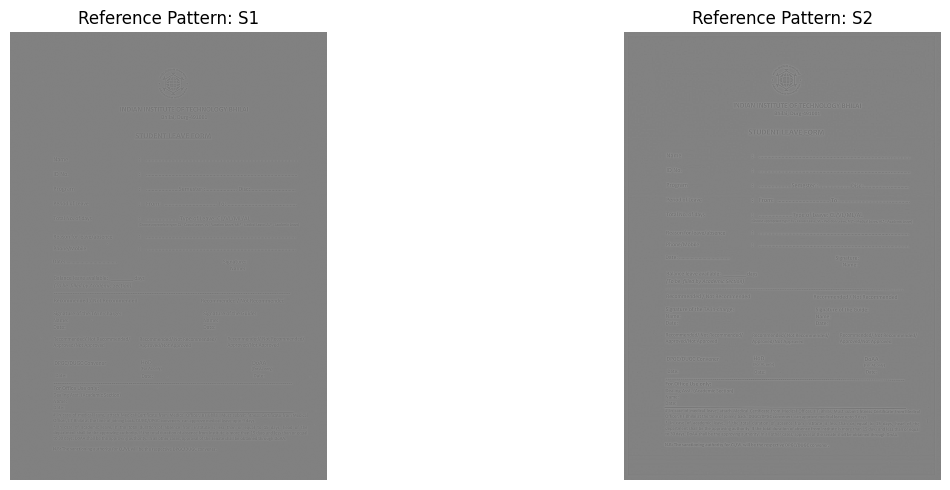

Testing S2: 100%|██████████| 1/1 [00:06<00:00,  6.27s/it]



Overall accuracy: 100.00%

Confusion Matrix:
Predicted ->
True | S2 S1
S2 |   1   0
S1 |   0   1
Accuracy for S2: 100.00%
Correct: 1/1
Accuracy for S1: 100.00%
Correct: 1/1

Visualizing sample images:


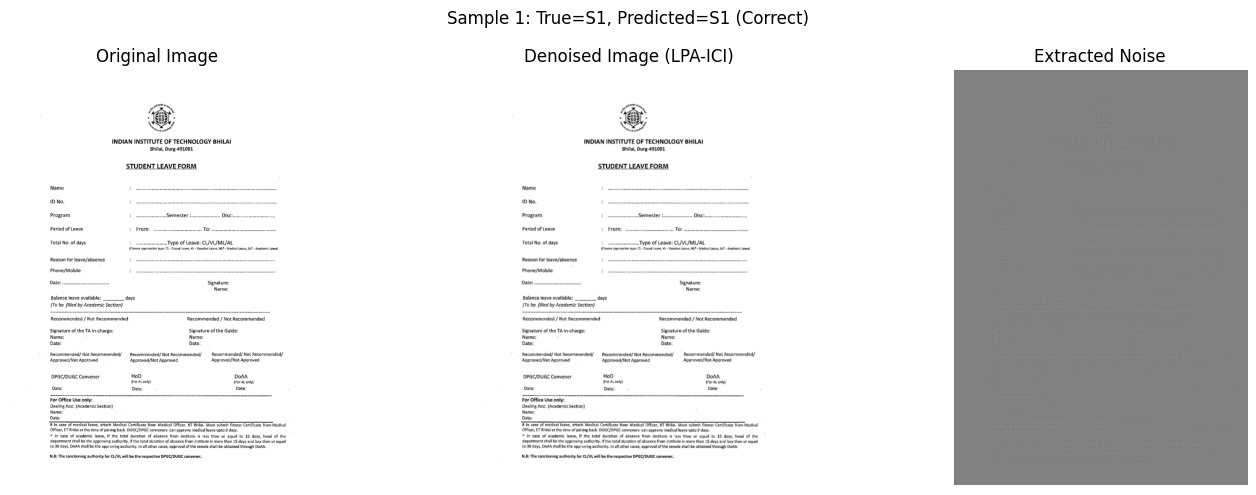

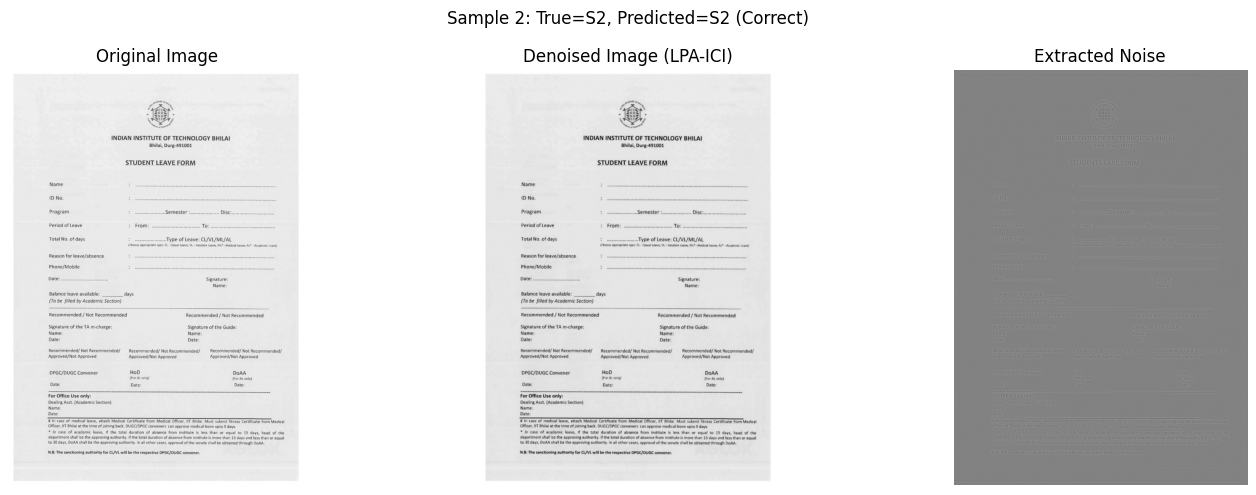

In [13]:
import os
import numpy as np
import shutil

# Example usage for 2D version
if __name__ == "__main__":
    # Initialize scanner identification with 2D patterns
    scanner_id = ScannerIdentification2D()

    # Define paths to scanner folders (containing all images)
    scanner_folders = [
        "/content/drive/MyDrive/Scanner_Dataset2/Scanner1",
        "/content/drive/MyDrive/Scanner_Dataset2/Scanner2",
    ]

    scanner_names = ["S1", "S2"]

    # Create output directories
    output_dir = "/content/processed_images_2d"
    temp_train_dir = "/content/temp_train_2d"
    temp_test_dir = "/content/temp_test_2d"

    os.makedirs(output_dir, exist_ok=True)
    os.makedirs(temp_train_dir, exist_ok=True)
    os.makedirs(temp_test_dir, exist_ok=True)

    # Process each scanner
    for folder, name in zip(scanner_folders, scanner_names):
        # Create scanner-specific subdirectories
        scanner_train_dir = os.path.join(temp_train_dir, name)
        scanner_test_dir = os.path.join(temp_test_dir, name)
        os.makedirs(scanner_train_dir, exist_ok=True)
        os.makedirs(scanner_test_dir, exist_ok=True)

        # Get the first image found in the folder
        image_path = None
        for root, _, files in os.walk(folder):
            for file in files:
                if file.lower().endswith(('.png', '.jpg', '.jpeg', '.tif', '.tiff', '.bmp')):
                    image_path = os.path.join(root, file)
                    break
            if image_path:
                break

        if not image_path:
            raise ValueError(f"No image found in {folder}")

        # Use the same image for both training and testing
        shutil.copy(image_path, os.path.join(scanner_train_dir, f"{name}_0000.jpg"))
        shutil.copy(image_path, os.path.join(scanner_test_dir, f"{name}_0000.jpg"))

    # Now use the temporary directories for training and testing
    train_folders = [os.path.join(temp_train_dir, name) for name in scanner_names]
    test_folders = [os.path.join(temp_test_dir, name) for name in scanner_names]

    # Create 2D reference patterns for each scanner (using 1 training image)
    for folder, name in zip(train_folders, scanner_names):
        print(f"Creating 2D reference pattern for {name} with 1 training image")
        scanner_id.create_reference_pattern(folder, name, num_train_images=1)

    # Visualize 2D reference patterns
    scanner_id.visualize_reference_patterns()

    # Evaluate on test images using 2D patterns (using the same image)
    accuracy, conf_matrix, labels, image_paths = scanner_id.evaluate(
        test_folders,
        scanner_names,
        num_test_images=1,
        save_images=True,
        output_dir=output_dir
    )

    # Print results
    print(f"\nOverall accuracy: {accuracy * 100:.2f}%")
    print("\nConfusion Matrix:")
    print("Predicted ->")
    print("True |", end="")
    for label in labels:
        print(f" {label}", end="")
    print()

    for i, label in enumerate(labels):
        print(f"{label} |", end="")
        for j in range(len(labels)):
            print(f" {conf_matrix[i][j]:3d}", end="")
        print()

    # Calculate individual accuracies
    for i, label in enumerate(labels):
        scanner_accuracy = conf_matrix[i, i] / np.sum(conf_matrix[i, :])
        print(f"Accuracy for {label}: {scanner_accuracy * 100:.2f}%")
        print(f"Correct: {conf_matrix[i, i]}/{np.sum(conf_matrix[i, :])}")

    # Visualize samples
    print("\nVisualizing sample images:")
    scanner_id.visualize_samples(image_paths, num_samples=5)

    # Clean up temporary directories
    shutil.rmtree(temp_train_dir)
    shutil.rmtree(temp_test_dir)